## Playing with StructureManagerWidget

In [2]:
#from aiidalab_widgets_base import OptimadeQueryWidget
from aiidalab_widgets_base import StructureBrowserWidget
from aiidalab_widgets_base import StructureManagerWidget
from aiidalab_widgets_base import StructureUploadWidget
from aiidalab_widgets_base import SmilesWidget

# Create the application steps
structure_manager_widget = StructureManagerWidget(
    importers=[
        StructureUploadWidget(title="From computer"),
        SmilesWidget(title='SMILES'),
        StructureBrowserWidget(title="AiiDA database"),
    ],
    node_class='StructureData',
)


display(structure_manager_widget)

StructureManagerWidget(children=(Tab(children=(StructureUploadWidget(children=(FileUpload(value={}, descriptio…

## Playing with RDKit

In [17]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
DrawingOptions.bondLineWidth=1.8

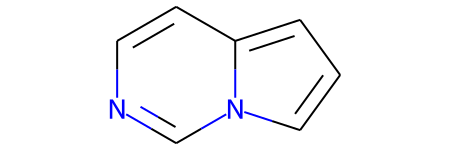

In [4]:
template = Chem.MolFromSmiles('c1nccc2n1ccc2')
#AllChem.Compute2DCoords(template)
template

In [5]:
Chem.Draw.IPythonConsole.InstallIPythonRenderer()

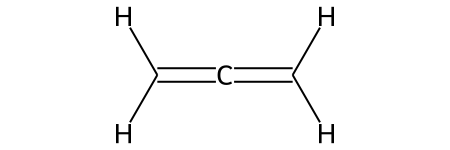

In [6]:
mol = Chem.MolFromSmiles('C=C=C')
mol = AllChem.AddHs(mol)
DrawingOptions.includeAtomNumbers=True
mol

In [7]:
import ipywidgets as widgets

In [8]:
w = widgets.IntSlider()
display(w)

IntSlider(value=0)

In [9]:
display(w)

IntSlider(value=0)

In [10]:
w.close()

In [40]:
a = widgets.FloatText()
b = widgets.FloatSlider()
display(a,b)

mylink = widgets.jslink((a, 'value'), (b, 'value'))


FloatText(value=0.0)

FloatSlider(value=0.0)

In [11]:
text = widgets.Text(
    value='',
    placeholder='SMILES input',
    description='String:',
    disabled=False
)
output = widgets.Output()

display(text, output)

def rdkit_2d_struct(smiles):
    m = Chem.MolFromSmiles(smiles)
    return m

def on_text_change(change):
    smiles = change['new']
    try:
        m = rdkit_2d_struct(smiles)
        with output:
            print(m)
    except:
        pass

text.observe(on_text_change, names='value')

Text(value='', description='String:', placeholder='SMILES input')

Output()

## ORCA SUBMISSION TEST



In [1]:
%aiida

Loaded AiiDA DB environment - profile name: default.

In [2]:
code = load_code('orca@localhost')
builder = code.get_builder()

In [3]:
params = {
    'charge': 0,
    'multiplicity': 1,
    'input_blocks': {
        'scf': {'convergence': 'tight'},
        'pal': {'nproc': 1},
    },
    'input_keywords': ['PBE', 'def2-svp','Opt'],
    'extra_input_keywords': []
}
builder.parameters = Dict(dict=params)

In [4]:
struct = load_node(pk=2)
builder.structure = struct

In [5]:
builder.metadata.options.withmpi = False
builder.metadata.options.resources = {
    'tot_num_mpiprocs': 1,
}
builder.metadata.description = "ORCA optimization"

In [6]:
from aiida.engine import submit
calc_node = submit(builder)

In [11]:
from aiidalab_widgets_base import ProcessNodesTreeWidget, ProcessMonitor
from aiidalab_ispg.widgets import NodeViewWidget
import ipywidgets as ipw

process_tree = ProcessNodesTreeWidget()
node_view = NodeViewWidget(layout={"width": "auto", "height": "auto"})
ipw.dlink(
    (process_tree, "selected_nodes"),
    (node_view, "node"),
    transform=lambda nodes: nodes[0] if nodes else None,
)

w = ipw.VBox(children=[process_tree, node_view])
process_monitor = ProcessMonitor(
            timeout=0.1,
            callbacks=[
                process_tree.update,
            ],
)
ipw.dlink((process_tree, "process"), (process_monitor, "process"))
workchain_pk = calc_node.pk
process_tree.process = load_node(workchain_pk)
display(w)

# Spectrum testing

In [3]:
from aiidalab_ispg.spectrum import Spectrum

Loading BokehJS ...

In [4]:
transition1 = {
    'energy': 1, # Excited energy in eV
    'osc_strength': '0.016510951'
}
transition2 = {
    'energy': 2.0, # Excited energy in eV
    'osc_strength': '0.0'
}
transitions = [transition1, transition2]
nsample = 1
spec = Spectrum(transitions, nsample)
x, y = spec.get_lorentzian_spectrum(0.3, 'ev', 'cross_section')

In [5]:
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, push_notebook
import ipywidgets as ipw
output_notebook()

Loading BokehJS ...

In [8]:
spec = Spectrum(transitions, nsample)

# TODO: Figure out how to use with ipywidgets
# https://github.com/bokeh/bokeh/issues/7023

# Initial spectrum
x, y = spec.get_lorentzian_spectrum(0.5, 'ev', 'cross_section')    
f = figure(title="Spectrum test",  x_axis_label='E / eV',   y_axis_label='I / cm^-2 * molecule ^ -1')
line = f.line(x, y, line_width=2)

def plot_spectrum(width):
    nsample = 1
    x, y = spec.get_gaussian_spectrum(width, 'ev', 'cross_section')
    line.data_source.data['x'] = x
    line.data_source.data['y'] = y
    push_notebook()

#handle = show(f, notebook_handle=True)
#i = ipw.interact(plot_spectrum, width=(0.05, 1.0, 0.05))

In [1]:
import ipywidgets as widgets
import numpy as np
from bokeh.io import push_notebook, show, output_notebook
import bokeh.plotting as plt
output_notebook()

class BokehFigureContext(widgets.Output):
    def __init__(self, fig):
        super().__init__()
        self._figure = fig
        self.on_displayed(lambda x: x.set_handle())
            
    def set_handle(self):
        self.clear_output()
        with self:
            self._handle = show(self._figure, notebook_handle=True)
            
    def get_handle(self):
        return self._handle
    
    def get_figure(self):
        return self._figure
    
    def update(self):
        push_notebook(handle=self._handle)

def create_bokeh_figure(*args, **kwargs):
    fig = plt.figure(*args, **kwargs)
    return BokehFigureContext(fig)

fc = create_bokeh_figure()
x = np.random.rand(10)
y = np.random.rand(10)
fc.get_figure().line(x, y)

display(widgets.HBox([fc]))

#for i in range(100):
#    rend = fc.get_figure().renderers[0]
#    rend.data_source.data = {
#        'x': np.random.rand(10),
#        'y': np.random.rand(10)
#    }
#    fc.update()

Loading BokehJS ...

In [2]:
x = np.random.rand(10)
y = np.random.rand(10)
fc.get_figure().line(x, y, line_color='black', name='test', line_dash='dashed')
fc.update()

In [9]:
len(fc.get_figure().renderers)
#fc.update()

2

In [10]:
fc.get_figure().select_one({'name': 'test'})

GlyphRenderer(id='1111', ...)

In [8]:
f = fc.get_figure()
f.select_one?

In [38]:
fc.update()

In [81]:
import traitlets
import ipywidgets as ipw
import matplotlib.pyplot as plt
import scipy
from scipy import constants
import numpy as np

class Spectrum(object):
    AUtoCm = 8.478354e-30
    COEFF = (
        scipy.constants.pi
        * AUtoCm ** 2
        * 1e4
        / (3 * scipy.constants.hbar * scipy.constants.epsilon_0 * scipy.constants.c)
    )
    # Transition Dipole to Osc. Strength in atomic units
    COEFF_NEW = COEFF * 3 / 2
    # COEFF =  scipy.constants.pi * AUtoCm**2 * 1e4 * scipy.constants.hbar / (2 * scipy.constants.epsilon_0 * scipy.constants.c * scipy.constants.m_e)

    def __init__(self, transitions, nsample):
        # Excitation energies in eV
        self.excitation_energies = np.array(
            [tr["energy"] for tr in transitions], dtype=float
        )
        # Oscillator strengths
        self.osc_strengths = np.array(
            [tr["osc_strength"] for tr in transitions], dtype=float
        )
        # Number of molecular geometries sampled from ground state distribution
        self.nsample = nsample

    # TODO
    def get_spectrum(self, x_min, x_max, x_units, y_units):
        """Returns a non-broadened spectrum as a tuple of x and y Numpy arrays"""
        n_points = int((x_max - x_min) / self.de)
        x = np.arange(x_min, x_max, self.de)
        y = np.zeros(n_points)
        return x, y

    # TODO: Make this function aware of units?
    def _get_energy_range(self, energy_unit):
        # NOTE: We don't include zero to prevent
        # division by zero when converting to wavelength
        x_min = max(0.01, self.excitation_energies.min() - 2.0)
        x_max = self.excitation_energies.max() + 2.0
        
        # conversion to nanometers is handled later
        if energy_unit.lower() == 'nm':
            return x_min, x_max
        
        #energy_factor_unit = self._get_energy_unit_factor(energy_unit)
        #x_min *= energy_factor_unit
        #x_max *= energy_factor_unit
        return x_min, x_max

    def _get_energy_unit_factor(self, unit):
        # TODO: We should probably start from atomic units
        if unit.lower() == 'ev':
            return 1.0
        # TODO: Construct these factors from scipy.constants
        elif unit.lower() == 'nm':
            return 1239.8
        elif unit.lower() == 'cm^-1':
            return 8065.7

    def get_gaussian_spectrum(self, sigma, x_unit, y_unit):
        """Returns Gaussian broadened spectrum"""

        x_min, x_max = self._get_energy_range(x_unit)

        # Conversion factor from eV to given energy unit
        # (should probably switch to atomic units as default)
        energy_unit_factor = self._get_energy_unit_factor(x_unit)
        
        energies = np.copy(self.excitation_energies)
        # Conversion to wavelength in nm is done at the end instead
        # Since it's not a linear transformation
        #if x_unit.lower() != 'nm':
        #    sigma *= energy_unit_factor
        #    energies *= energy_unit_factor
        
        # TODO: How to determine this properly to cover a given interval?
        n_sample = 500
        x = np.linspace(x_min, x_max, num=n_sample)
        y = np.zeros(len(x))

        normalization_factor = (
            1 / np.sqrt(2 * scipy.constants.pi) / sigma / self.nsample
        )
        # TODO: Support other intensity units
        unit_factor = self.COEFF_NEW
        for exc_energy, osc_strength in zip(
            energies, self.osc_strengths
        ):
            prefactor = normalization_factor * unit_factor * osc_strength
            y += prefactor * np.exp(-((x - exc_energy) ** 2) / 2 / sigma ** 2)
        
        
        if x_unit.lower() == 'nm':
            x, y = self._convert_to_nanometers(x, y)
        else:
            x *= energy_unit_factor
            
        return x, y

    
    def get_lorentzian_spectrum(self, tau, x_unit, y_unit):
        """Returns Gaussian broadened spectrum"""
        # TODO: Determine x_min automatically based on transition energies
        # and x_units
        x_min, x_max = self._get_energy_range(x_unit)

        # Conversion factor from eV to given energy unit
        # (should probably switch to atomic units as default)
        energy_unit_factor = self._get_energy_unit_factor(x_unit)
        
        energies = np.copy(self.excitation_energies)
        
        # TODO: How to determine this properly to cover a given interval?
        n_sample = 500
        x = np.linspace(x_min, x_max, num=n_sample)
        y = np.zeros(len(x))

        normalization_factor = tau / 2 / scipy.constants.pi / self.nsample
        unit_factor = self.COEFF_NEW

        for exc_energy, osc_strength in zip(
            energies, self.osc_strengths
        ):
            prefactor = normalization_factor * unit_factor * osc_strength
            y += prefactor / ((x - exc_energy) ** 2 + (tau ** 2) / 4)

        if x_unit.lower() == 'nm':
            x, y = self._convert_to_nanometers(x, y)
        else:
            x *= energy_unit_factor
            
        return x, y

    def _convert_to_nanometers(self, x, y):
        x = self._get_energy_unit_factor('nm') / x
        # Filtering out ultralong wavelengths
        nm_thr = 1000
        to_delete = []
        for i in range(len(x)):
            if x[i] > 1000:
                to_delete.append(i)
        x = np.delete(x, to_delete)
        y = np.delete(y, to_delete)
        return x, y
            

class SpectrumWidget(ipw.VBox):

    transitions = traitlets.List()

    def __init__(self, **kwargs):
        title = ipw.HTML(
            """<div style="padding-top: 0px; padding-bottom: 0px">
            <h4>UV/Vis Spectrum</h4></div>"""
        )

        # TODO: Remove this debugging output later
        self.output = ipw.Output()

        self.spectrum_container = ipw.Box()
        self.width_slider = ipw.FloatSlider(
            min=0.05, max=1, step=0.05, value=0.5, description="Width / eV"
        )
        self.kernel_selector = ipw.ToggleButtons(
            options=["gaussian", "lorentzian"],  # TODO: None option
            description="Broadening kernel:",
            disabled=False,
            button_style="info",  # 'success', 'info', 'warning', 'danger' or ''
            tooltips=[
                "Description of slow",
                "Description of regular",
                "Description of fast",
            ],
        )
        self.xunit_selector = ipw.RadioButtons(
                # TODO: Make an enum with different energy units
                options=["eV", "nm", "cm^-1"],
                disabled=False,
                description="Energy unit",
        )

        controls = ipw.HBox(children=[
                    ipw.VBox(children=[
                        self.kernel_selector,
                        self.width_slider]),
                    self.xunit_selector]
                    )

        super().__init__(
            [
                title,
                controls,
                self.spectrum_container,
                self.output,
            ],
            **kwargs,
        )

    def _init_figure(self):
         self.figure = plt.Figure()
        
    def _plot_spectrum(self, kernel, width, energy_unit):
        nsample = 1
        spec = Spectrum(self.transitions, nsample)
        intensity_unit = "cm^-2 per molecule"
        if kernel == "lorentzian":
            x, y = spec.get_lorentzian_spectrum(width, energy_unit, intensity_unit)
        elif kernel == "gaussian":
            x, y = spec.get_gaussian_spectrum(width, energy_unit, intensity_unit)
        else:
            with self.output:
                print("Invalid broadening type")
                return

        # TODO: Maybe determine optimal min max of x and y axes
        # so that they don't change for different widths?
        # 
        # Remove previous lines.
        #[l.remove() for l in self.axes.lines]
        plt.plot(x, y)
        plt.xlabel(f"Energy / {energy_unit}")
        plt.ylabel(f"Intensity / {intensity_unit}")
        plt.show()

    def _validate_transitions(self):
        # TODO: Maybe use named tuple instead of dictionary?
        for tr in self.transitions:
            if not isinstance(tr, dict) or (
                "energy" not in tr or "osc_strength" not in tr
            ):
                with self.output:
                    print("Invalid transition", tr)
                    return False
        return True

    def _show_spectrum(self):
        self.output.clear_output()
        self._init_figure()
        if self._validate_transitions:
            spectrum = ipw.interactive_output(
                self._plot_spectrum,
                {"width": self.width_slider,
                 "kernel": self.kernel_selector,
                 "energy_unit": self.xunit_selector},
            )
            self.spectrum_container.children = [spectrum]
        else:
            # TODO: Add proper error handling
            raise KeyError

    @traitlets.observe("transitions")
    def _observe_transitions(self, change):
        self._show_spectrum()

In [82]:
s = SpectrumWidget()
transition1 = {
    'energy': 2, # Excited energy in eV
    'osc_strength': '0.016510951'
}
transition2 = {
    'energy': 3.0, # Excited energy in eV
    'osc_strength': '0.02'
}
transitions = [transition1, transition2]
s.transitions = transitions
s

SpectrumWidget(children=(HTML(value='<div style="padding-top: 0px; padding-bottom: 0px">\n            <h4>UV/V…

In [56]:
x = np.full(6, 4.0)

In [58]:
x[5] = 10
x = np.flip(x)

In [60]:
x = np.full(6, 4.0)
x.resize(3)

In [69]:
np.delete(x, [1])

array([ 4., 56.])

In [68]:
x[2] = 56
x

array([ 4.,  4., 56.])

## Storing experimental spectrum in the database

In [18]:
from aiida.plugins import DataFactory
import numpy as np
import aiida

aiida.load_profile()

XyData = DataFactory('array.xy')
xy = XyData()

In [22]:
xy.source?

In [48]:
bibliography = ' I. Magneron, R. Thévenet, A. Mellouki, G. Le Bras, G.K. Moortgat, and K. Wirtz, "A study of the photolysis and OH-initiated oxidation of acrolein and trans-crotonaldehyde", J. Phys. Chem. A 106, 2526-2537 (2002); DOI: 10.1021/jp013413a '
source = {'db_name': 'UV/VIS Spectral Atlas',
          'db_uri': 'http://satellite.mpic.de/spectral_atlas',
          'uri': 'http://satellite.mpic.de/spectral_atlas/cross_sections/Organics%20(carbonyls)/Aldehydes(aliphatic)/CH2=CHCHO_Magneron(2002)_298K_282-390nm.txt',
          'id': 'HGINCPLSRVDWNT-UHFFFAOYSA-N', # inChi key
          'version': '2022',
          'description': bibliography,
          'license': '?'
}
energy_nm = np.array([282,284,286,288,290,292,294,296,298,300,302,304,306,308,310,312,314,316,318,320,322,324,326,328,330,332,334,336,338,340,342,344,346,348,350,352,354,356,358,360,362,364,366,368,370,372,374,376,378,380,382,384,386,388,390]) 
y = np.array([8.4e-21,9.7e-21,1.08e-20,1.23e-20,1.46e-20,1.62e-20,1.8e-20,1.97e-20,2.18e-20,2.47e-20,2.7e-20,2.85e-20,3.09e-20,3.29e-20,3.59e-20,3.92e-20,4.15e-20,4.21e-20,4.47e-20,4.65e-20,5.08e-20,5.17e-20,5.34e-20,5.2e-20,5.31e-20,5.44e-20,5.8e-20,6.24e-20,5.46e-20,5.31e-20,5.1e-20,5.12e-20,5.3e-20,5.17e-20,5.94e-20,5.79e-20,4.18e-20,3.63e-20,3.28e-20,3.92e-20,3.72e-20,2.86e-20,3.74e-20,3.82e-20,2.17e-20,1.58e-20,1.14e-20,1.14e-20,1.24e-20,1.1e-20,8.4e-21,7.9e-21,1.18e-20,4.9e-21,2.5e-21])
xy.set_x(energy_nm, 'energy', 'nm')
xy.set_y(y, 'cross section', 'cm^2')

In [49]:
xy.set_source(source=source)

In [52]:
xy.set_attribute('smiles', 'C=CC=O')

In [53]:
xy.attributes

{'x_units': 'nm',
 'array|x_array': [55],
 'array|y_array_0': [55],
 'y_names': ['cross section'],
 'y_units': ['cm^2'],
 'x_name': 'energy',
 'source': {'db_name': 'UV/VIS Spectral Atlas',
  'db_uri': 'http://satellite.mpic.de/spectral_atlas',
  'uri': 'http://satellite.mpic.de/spectral_atlas/cross_sections/Organics%20(carbonyls)/Aldehydes(aliphatic)/CH2=CHCHO_Magneron(2002)_298K_282-390nm.txt',
  'id': 'HGINCPLSRVDWNT-UHFFFAOYSA-N',
  'version': '2022',
  'description': ' I. Magneron, R. Thévenet, A. Mellouki, G. Le Bras, G.K. Moortgat, and K. Wirtz, "A study of the photolysis and OH-initiated oxidation of acrolein and trans-crotonaldehyde", J. Phys. Chem. A 106, 2526-2537 (2002); DOI: 10.1021/jp013413a ',
  'license': '?'},
 'smiles': 'C=CC=O'}

In [74]:
new_xy = xy.clone()

In [77]:
new_xy.set_extra('smiles', xy.attributes['smiles'])
new_xy.delete_attribute('smiles')
new_xy.extras

{'smiles': 'C=CC=O'}

In [78]:
node = new_xy.store()

In [80]:
node.extras

{'smiles': 'C=CC=O',
 '_aiida_hash': '210ede15085eb35c2af9a2e1cc2fb7c4000f2f55ff46d695959461e9bc7bc1d1'}

In [66]:
node.extras

{'_aiida_hash': '210ede15085eb35c2af9a2e1cc2fb7c4000f2f55ff46d695959461e9bc7bc1d1'}

In [101]:
from aiida.orm import QueryBuilder
XyData = DataFactory('array.xy')
qb = QueryBuilder()
qb.append(XyData, filters={
    'extras.smiles': 'C=CC=O'
})
qb.all()

[[<XyData: uuid: 81f590af-08c7-4e80-b900-71e1314dce9c (pk: 521)>]]

In [159]:
from aiida.plugins import WorkflowFactory
from aiida.orm import load_code
wch = WorkflowFactory('orca.base')
orca = load_code('orca')

In [171]:
c = wch.get_builder()
c.orca.file?

In [5]:
from aiidalab_qe_workchain import QeAppWorkChain
w = QeAppWorkChain
w.get_builder()

{'metadata': {}, 'relax': {'metadata': {}, 'base': {'metadata': {}, 'pw': {'metadata': {'options': {'stash': {}}}, 'pseudos': {}}}, 'base_final_scf': {'metadata': {}, 'pw': {'metadata': {'options': {'stash': {}}}, 'pseudos': {}}}}, 'bands': {'metadata': {}, 'scf': {'metadata': {}, 'pw': {'metadata': {'options': {'stash': {}}}, 'pseudos': {}}}, 'bands': {'metadata': {}, 'pw': {'metadata': {'options': {'stash': {}}}, 'pseudos': {}}}}, 'pdos': {'metadata': {}, 'scf': {'metadata': {}, 'pw': {'metadata': {'options': {'stash': {}}}, 'pseudos': {}}}, 'nscf': {'metadata': {}, 'pw': {'metadata': {'options': {'stash': {}}}, 'pseudos': {}}}, 'dos': {'metadata': {'options': {'stash': {}}}}, 'projwfc': {'metadata': {'options': {'stash': {}}}}}}

## Testing basic ORCA workflow

In [1]:
from aiidalab_ispg.workflows.base import OrcaRelaxAndTDDFTWorkChain
from aiida.orm import load_node, load_code
from aiida.orm import Dict, Bool, Int
from aiida import load_profile
load_profile()
w = OrcaRelaxAndTDDFTWorkChain
b = w.get_builder()

In [14]:
parameters_opt = {
    'charge': 0,
    'multiplicity': 1,
    'input_blocks': {
        'scf': {'convergence': 'loose'},
        'pal': {'nproc': 1},
    },
    'input_keywords': ['LSD', 'sto-3g', 'Opt'],
    'extra_input_keywords': []
}
parameters_tddft = {
    'charge': 0,
    'multiplicity': 1,
    'input_blocks': {
        'scf': {'convergence': 'loose'},
        'pal': {'nproc': 1},
        'tddft': {'nroots': 3},
    },
    'input_keywords': ['LSD', 'sto-3g'],
    'extra_input_keywords': []
}
metadata = {
    'options': {
        'withmpi': False,
        'resources': {
            'tot_num_mpiprocs': 1,
        }
    },
    'description': 'ORCA calculation',  
}
structure = load_node(pk=1)
code = load_code('orca')

b.exc.orca.parameters = Dict(dict=parameters_tddft)
b.exc.orca.metadata = metadata
b.exc.clean_workdir = Bool(True)

# Hack for now
b.opt.orca = b.exc.orca
b.opt.orca.parameters = Dict(dict=parameters_opt)

b.structure = structure
b.code = code
b.optimize = Bool(False)

In [15]:
from aiida.engine import submit
from aiida.engine.daemon.client import get_daemon_client
daemon = get_daemon_client()
daemon.restart_daemon(wait=True)
workchain_node = submit(b)

## ProcessTreeWidget to see workflows

In [10]:
from aiidalab_widgets_base import ProcessNodesTreeWidget, ProcessMonitor
from aiidalab_ispg.widgets import NodeViewWidget
import ipywidgets as ipw

process_tree = ProcessNodesTreeWidget()
node_view = NodeViewWidget(layout={"width": "auto", "height": "auto"})
ipw.dlink(
    (process_tree, "selected_nodes"),
    (node_view, "node"),
    transform=lambda nodes: nodes[0] if nodes else None,
)

w = ipw.VBox(children=[process_tree, node_view])
process_monitor = ProcessMonitor(
            timeout=0.1,
            callbacks=[
                process_tree.update,
            ],
)
ipw.dlink((process_tree, "process"), (process_monitor, "process"))
workchain_pk = calc_node.pk
process_tree.process = load_node(workchain_pk)
display(w)

In [17]:
from aiidalab_ispg.spectrum import Spectrum, SpectrumWidget
from aiida import load_profile

In [18]:
s = SpectrumWidget()

In [20]:
s

SpectrumWidget(children=(HTML(value='<div style="padding-top: 0px; padding-bottom: 0px">\n            <h4>UV/V…

In [22]:
load_profile()

In [32]:
s.smiles = 'C=CC=O'

Experimental spectrum for C=CC=O available!
[<XyData: uuid: 81f590af-08c7-4e80-b900-71e1314dce9c (pk: 521)>]
